<a href="https://colab.research.google.com/github/wnsghks622/RAGTofCom/blob/main/AgenticEconGameArchitecture_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install langgraph langsmith langchain_groq langchain_core langchain_community --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
from langgraph.graph import Graph, StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain.chat_models.base import BaseChatModel
from langchain_core.messages import BaseMessage # message abstraction

from typing import TypedDict, Annotated, Sequence, Callable, List, Dict, Literal
from dataclasses import dataclass, field
from collections import defaultdict
from typing_extensions import TypedDict
import pprint as pp
import operator
import numpy as np

import os, getpass
from IPython.display import Image, display

# utility to visualize the workflow created
def visualize_workflow(workflow):
    display(Image(workflow.get_graph().draw_mermaid_png()))

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Version 3


The Player class represents an individual agent in the game system. It encapsulates the agent's identity, decision-making capabilities, and personal characteristics.
Attributes

- `id`: A unique integer identifier for the player
- `llm`: A language model instance used for decision-making (BaseChatModel)
- `prompt_template`: A template for formatting prompts sent to the language model
- `name`: The player's display name (defaults to "Player_{id}")
- `profile`: Additional player characteristics or parameters (optional)

Methods

`__post_init__()`: Automatically assigns a default name if none is provided

In [2]:
@dataclass
class Player:
    id: int
    llm: BaseChatModel
    prompt_template: PromptTemplate
    name: str = None
    profile: str = None

    def __post_init__(self):
        if self.name is None:
            self.name = f"Player_{self.id}"


The `GameStatistics` class maintains comprehensive records of game progression and outcomes. It tracks individual player actions and aggregate game metrics.
Attributes

- `rounds_played`: Counter for completed game rounds
- `total_claimed`: Sum of all resources claimed by players
- `player_claims`: Dictionary mapping player IDs to their claim history
- `final_pot`: Remaining resources at game end
- `game_completed`: Boolean indicating if the game has concluded
- `end_condition`: Game termination reason (POT_DEPLETED, MAX_ITERATIONS, or ONGOING)

Methods

`compute_summary()`: Generates a detailed statistical report including:

- Overall game metrics (rounds played, total claims)
- Per-player statistics (average, maximum, minimum claims)
- Resource depletion analysis
- Game termination details

In [8]:
@dataclass
class GameStatistics:
    rounds_played: int = 0
    total_claimed: int = 0
    player_claims: Dict[int, List[int]] = field(default_factory=lambda: defaultdict(list))
    final_pot: int = 0
    game_completed: bool = False
    end_condition: Literal["POT_DEPLETED", "MAX_ITERATIONS", "ONGOING"] = "ONGOING"

    def compute_summary(self) -> Dict:
        """Compute summary statistics for the game"""
        if not self.game_completed:
            return {"status": "Game not completed"}

        return {
            "rounds_played": self.rounds_played,
            "total_claimed": self.total_claimed,
            "end_condition": self.end_condition,
            "average_claimed_per_round": self.total_claimed / self.rounds_played if self.rounds_played > 0 else 0,
            "player_statistics": {
                player_id: {
                    "total_claimed": sum(claims),
                    "average_claim": np.mean(claims),
                    "max_claim": max(claims),
                    "min_claim": min(claims),
                    "std_claim": np.std(claims) if len(claims) > 1 else 0,
                    "decisions_by_round": claims
                }
                for player_id, claims in self.player_claims.items()
            },
            "final_pot": self.final_pot,
            "resource_depletion_rate": (self.total_claimed / self.rounds_played) if self.rounds_played > 0 else 0
        }

The `GameState` class defines the structure for maintaining the current state of the game. It uses TypedDict for strict type checking and includes annotations for sequence operations.
Attributes

- `messages`: Sequence of game event messages
- `players_pot`: Current total resources claimed by players
- `game_pot`: Remaining resources in the game
- `iterations`: Maximum number of game rounds
- `stage_number`: Current round number
- `p1_decisions`: History of Player 1's decisions
- `p2_decisions`: History of Player 2's decisions

This state management system supports tracking both individual player actions and aggregate game progress while maintaining type safety through Python's typing system.

In [9]:
class GameState(TypedDict):
    messages: Annotated[Sequence[str], operator.add]
    players_pot: int
    game_pot: int
    iterations: int
    stage_number: int
    p1_decisions: Annotated[Sequence[str], operator.add]
    p2_decisions: Annotated[Sequence[str], operator.add]
    p3_decisions: Annotated[Sequence[str], operator.add]
    p4_decisions: Annotated[Sequence[str], operator.add]

The `AgenticGame` class implements a multi-agent game framework where players interact through a directed graph architecture to make decisions about resource allocation. The class orchestrates game flow, manages state transitions, and collects statistics about player behavior and game outcomes.

The class is built around three primary components:

- A state management system that tracks game progression
- A node-based architecture that processes player decisions
- A statistical tracking system that analyzes game outcomes

**Initialization Parameters**

- `game_state`: A TypedDict containing the initial state of the game
- `players`: A list of Player objects representing game participants
- `state_parameters`: A dictionary containing game configuration parameters, including:
    - `game_pot`: Initial resource amount available
    - `iterations`: Maximum number of game rounds

**Key Methods**

*Graph Creation and Management*

`def create_graph(self)`

Creates a directed graph that defines the game's flow. The graph consists of several node types:

- Supervisor Node: Controls game progression and stage transitions
- Player Nodes: Handle individual player decision-making
- Aggregator Node: Processes and combines player decisions

*Game Execution*

`def run_game(self)`

Executes the game by:

- Validating graph creation
- Streaming state updates through the node network
- Processing player decisions
- Updating game statistics

*Statistical Analysis*

`def get_game_statistics(self) -> Dict`

`def plot_game_statistics(self)`

These methods provide analytical capabilities:

- get_game_statistics(): Returns computed game metrics
- plot_game_statistics(): Generates visualizations of game progression and outcomes using matplotlib

*Node Architecture*

***Supervisor Node***

`def _create_supervisor_node(self) -> Callable`

Manages game stages and round transitions. Increments the round counter and generates stage announcements.

***Player Node***

`def _create_player_node(self, player_id: int) -> Callable`

Handles individual player decision-making by:

- Formatting player-specific prompts
- Invoking the language model for decisions
- Validating and recording player claims

***Aggregator Node***

`def _create_aggregator_node(self) -> Callable`

Processes collective player decisions by:

- Summing player claims
- Updating the game pot
- Advancing the game stage

**Error Handling**

The class implements several validation checks:

- Ensures at least one player is provided
- Validates player ID uniqueness
- Verifies graph creation before game execution
- Handles invalid player decisions gracefully

**Game Termination**

Games can end under two conditions:

- POT_DEPLETED: When available resources are exhausted
- MAX_ITERATIONS: When the maximum number of rounds is reached

These conditions are tracked in the GameStatistics instance and can be analyzed post-game.

**Implementation Considerations**

When using this class, consider:

- Language model configuration affects player decision quality
- Prompt template design is crucial for consistent player behavior
- Graph structure determines game flow and interaction patterns
- Statistical analysis provides insights into emergent player strategies

This implementation supports research into multi-agent behavior, resource allocation dynamics, and language model-based decision-making in structured environments.

In [6]:
class AgenticGame:
    def __init__(self,
                 game_state: TypedDict,
                 players: List[Player],
                 state_parameters: dict):

        self.game_state = game_state
        self.players = {player.id: player for player in players}
        self.state_parameters = state_parameters
        self.graph = None
        self.stats = GameStatistics()
        self.initial_pot = state_parameters['game_pot']
        self.max_iterations = state_parameters['iterations']

    
        # Validate players
        if not players:
            raise ValueError("At least one player must be provided")
        if len(set(p.id for p in players)) != len(players):
            raise ValueError("Player IDs must be unique")

        # Create node functions that only take state as parameter
        self.nodes = {
            "supervisor": self._create_supervisor_node(),
            **{f"player{p.id}": self._create_player_node(p.id) for p in players},
            "aggregator": self._create_aggregator_node(),
        }

    def _create_supervisor_node(self) -> Callable:
        def supervisor_node(state: GameState) -> GameState:
            self.stats.rounds_played += 1
            return {
                'messages': [f"---- Stage {state['stage_number']} ----"]
            }
        return supervisor_node

    def _create_player_node(self, player_id: int) -> Callable:
        player = self.players[player_id]

        def player_node(state: GameState) -> GameState:
            # Create a log of what each player chose last round
            previous_decisions = "\n".join(f"Player {player_id} took {state[f'p{player_id}_decisions'][-1]}" if state.get(f'p{player_id}_decisions') else f"Player {player_id}: No previous decision"
            for player_id in self.players)

            print(previous_decisions)

            prompt = player.prompt_template.format(
                # add id 
                num_players=len(self.players),
                game_pot=state['game_pot'],
                stages_left=state['iterations'] - state['stage_number'],
                profile=player.profile,
                previous_decisions=previous_decisions 
            )

            decision = player.llm.invoke(prompt).content
            # Store the decision in our statistics
            try:
                claim = int(decision) # right now this logic depends on the LLM returning a single integer. Could be updated with more robust parsing, but better to work on prompt first
                self.stats.player_claims[player_id].append(claim)
            except ValueError:
                print(f"Warning: {player.name} made invalid decision: {decision}")
                claim = 0
                self.stats.player_claims[player_id].append(claim)

            return {
                'messages': [str(claim)],
                f'p{player_id}_decisions': [str(claim)]
            }

        return player_node

    def _create_aggregator_node(self) -> Callable:
        def aggregator_node(state: GameState) -> GameState:
            try:
                players_aggregate = sum([int(decision) for decision in state['messages'][-len(self.players):]])
                self.stats.total_claimed += players_aggregate

                new_pot = state['game_pot'] - players_aggregate

                # doubling what's remaining in the pot after each stage
                double_pot = new_pot * 2
                self.stats.final_pot = double_pot

                return {
                    'players_pot': players_aggregate,
                    'game_pot': double_pot,
                    'stage_number': state['stage_number'] + 1
                }
            except ValueError:
                print("Warning: Invalid decision format in aggregator")
                return {
                    'players_pot': 0,
                    'game_pot': state['game_pot'] * 2,
                    'stage_number': state['stage_number'] + 1
                }
        return aggregator_node

    def _decision_node(self, state: GameState) -> bool:
        should_continue = state['game_pot'] > 0 and state['iterations'] > state['stage_number']

        if not should_continue:
            self.stats.game_completed = True
            if state['game_pot'] <= 0:
                self.stats.end_condition = "POT_DEPLETED"
            elif state['iterations'] <= state['stage_number']:
                self.stats.end_condition = "MAX_ITERATIONS"

        return should_continue

    def create_graph(self):
        graph = StateGraph(self.game_state)

        # Add nodes using the factory-created node functions
        for node_name, node_func in self.nodes.items():
            graph.add_node(node_name, node_func)

        # Add edges
        graph.add_edge(START, 'supervisor')

        # Add edges from supervisor to each player
        for player_id in self.players:
            graph.add_edge('supervisor', f'player{player_id}')

        # Add edges from each player to aggregator
        for player_id in self.players:
            graph.add_edge(f'player{player_id}', 'aggregator')

        graph.add_conditional_edges(
            'aggregator',
            self._decision_node,
            {
                True: 'supervisor',
                False: END
            }
        )

        self.graph = graph.compile()

    def run_game(self):
        if self.graph is None:
            raise ValueError("Graph not created. Call create_graph() first.")

        for chunk in self.graph.stream(self.state_parameters, stream_mode='values'):
            print(chunk)

    def get_game_statistics(self) -> Dict:
        """Return computed statistics about the game"""
        if not self.stats.game_completed:
            print("Warning: Getting statistics for incomplete game")
        return self.stats.compute_summary()

    def plot_game_statistics(self):
        """Create visualizations of game statistics"""
        if not self.stats.game_completed:
            print("Cannot plot statistics for incomplete game")
            return

        try:
            import matplotlib.pyplot as plt

            # Create figure and axis
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            # Plot 1: Player decisions over time
            for player_id, claims in self.stats.player_claims.items():
                player = self.players[player_id]
                ax1.plot(range(1, len(claims) + 1), claims,
                        label=f'{player.name}',
                        marker='o')

            ax1.set_title('Player Decisions by Round')
            ax1.set_xlabel('Round')
            ax1.set_ylabel('Decision Amount')
            ax1.legend()
            ax1.grid(True)

            # Plot 2: Remaining pot over time
            remaining_pot = [self.initial_pot]
            for round_num in range(len(list(self.stats.player_claims.values())[0])):
                round_claims = sum(player_claims[round_num]
                                 for player_claims in self.stats.player_claims.values())
                remaining_pot.append(remaining_pot[-1] - round_claims)

            ax2.plot(range(len(remaining_pot)), remaining_pot,
                    label='Remaining Pot', marker='s', color='green')
            ax2.set_title(f'Pot Depletion\nEnd Condition: {self.stats.end_condition}')
            ax2.set_xlabel('Round')
            ax2.set_ylabel('Pot Amount')
            ax2.legend()
            ax2.grid(True)

            plt.tight_layout()
            plt.show()

        except ImportError:
            print("matplotlib is required for plotting. Please install it first.")

In [193]:
# prompt v1 - no memory of past decisions
player_prompt_template = '''
    You are one out of {num_players} players in an economic game with the following behavioral profile:
    {profile}
    -----
    You must choose how much of the {game_pot} dollars pot to claim for yourself.
    Other players will make their decisions simultaneously.
    Your goal is to maximize your profits (i.e., how much you are left with at the end of the game).
    If the total pot is depleted then the game ends and no player receives revenue.
    The remaining money in the pot doubles after each round.
    
    There are {stages_left} rounds left to play. 


    Your response must only contain the single integer between 0 and {game_pot} representing your decision.
'''

player_prompt = PromptTemplate(
    input_variables=["num_players", "profile", "game_pot", "stages_left"],
    template=player_prompt_template,
)

In [198]:
# prompt v2 - have information about what each player decided to take last round
player_prompt_template = '''
    You are one out of {num_players} players in an economic game with the following behavioral profile:
    {profile}
    -----
    You must choose how much of the {game_pot} dollars pot to claim for yourself.
    Other players will make their decisions simultaneously.
    Your goal is to maximize your profits (i.e., how much you are left with at the end of the game).
    If the total pot is depleted then the game ends and no player receives revenue.
    The remaining money in the pot doubles after each round.
    
    There are {stages_left} rounds left to play. 

    Your response must only contain the single integer between 0 and {game_pot} representing your decision.

    These are the decisions all players made at the last round.
    {previous_decisions}
'''

player_prompt = PromptTemplate(
    input_variables=["num_players", "profile", "game_pot", "stages_left", "previous_decisions"],
    template=player_prompt_template,
)

In [200]:
# test run
test_input = {'messages': [],
              'players_pot': 0,
              'game_pot': 100,
              'iterations': 8,
              'stage_number': 1,
              'p1_decisions': [],
              'p2_decisions': [],
              'p3_decisions': [],
              'p4_decisions': []
              }

# Create different LLMs for different players
llm1 = ChatGroq(model_name="llama-3.3-70b-versatile", temperature=0)
llm2 = ChatGroq(model_name="llama3-8b-8192", temperature=0)
llm3 = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0)

# Create players with different configurations
players = [
    Player(
        id=1,
        name="Conservative",
        profile="You are a conservative agent. Try to maximize your profit without depleting the pot by carefully observing other players' decisions.", # should be replaced by RAG profile
        llm=llm1,
        prompt_template=player_prompt
    ),
    Player(
        id=2,
        name="Aggressive",
        profile="You are an aggressive agent. Try to maximize your profit without depleting the pot by carefully observing other players' decisions.", # should be replaced by RAG profile
        llm=llm1,
        prompt_template=player_prompt
    ),
    Player(
        id=3,
        name="Progressive",
        profile="You are a progressive agent. Try to maximize your profit without depleting the pot by carefully observing other players' decisions.", # should be replaced by RAG profile
        llm=llm1,
        prompt_template=player_prompt
    ), # add more players if you want
    Player(
        id=4,
        name="Smart",
        profile="You are a smart agent. Try to maximize your profit without depleting the pot by carefully observing other players' decisions.", # should be replaced by RAG profile
        llm=llm1,
        prompt_template=player_prompt
    )
]

# Create and run game
game = AgenticGame(
    game_state=GameState,
    players=players,
    state_parameters=test_input
)
game.create_graph()
game.run_game()


{'messages': [], 'players_pot': 0, 'game_pot': 100, 'iterations': 8, 'stage_number': 1, 'p1_decisions': [], 'p2_decisions': [], 'p3_decisions': [], 'p4_decisions': []}
{'messages': ['---- Stage 1 ----'], 'players_pot': 0, 'game_pot': 100, 'iterations': 8, 'stage_number': 1, 'p1_decisions': [], 'p2_decisions': [], 'p3_decisions': [], 'p4_decisions': []}
Player 1: No previous decision
Player 2: No previous decision
Player 3: No previous decision
Player 4: No previous decision
Player 1: No previous decision
Player 2: No previous decision
Player 3: No previous decision
Player 4: No previous decision
Player 1: No previous decision
Player 2: No previous decision
Player 3: No previous decision
Player 4: No previous decision
Player 1: No previous decision
Player 2: No previous decision
Player 3: No previous decision
Player 4: No previous decision
{'messages': ['---- Stage 1 ----', '0', '20', '0', '0'], 'players_pot': 0, 'game_pot': 100, 'iterations': 8, 'stage_number': 1, 'p1_decisions': ['0']

In [202]:
# Get statistics and plot results
stats = game.get_game_statistics()
pp.pprint(stats)

{'average_claimed_per_round': 132.14285714285714,
 'end_condition': 'MAX_ITERATIONS',
 'final_pot': 280,
 'player_statistics': {1: {'average_claim': 24.285714285714285,
                           'decisions_by_round': [0, 10, 15, 15, 10, 120, 0],
                           'max_claim': 120,
                           'min_claim': 0,
                           'std_claim': 39.49941875056712,
                           'total_claimed': 170},
                       2: {'average_claim': 44.285714285714285,
                           'decisions_by_round': [20, 20, 20, 20, 30, 200, 0],
                           'max_claim': 200,
                           'min_claim': 0,
                           'std_claim': 64.11087334947679,
                           'total_claimed': 310},
                       3: {'average_claim': 25.714285714285715,
                           'decisions_by_round': [0, 10, 15, 20, 15, 120, 0],
                           'max_claim': 120,
                           'm

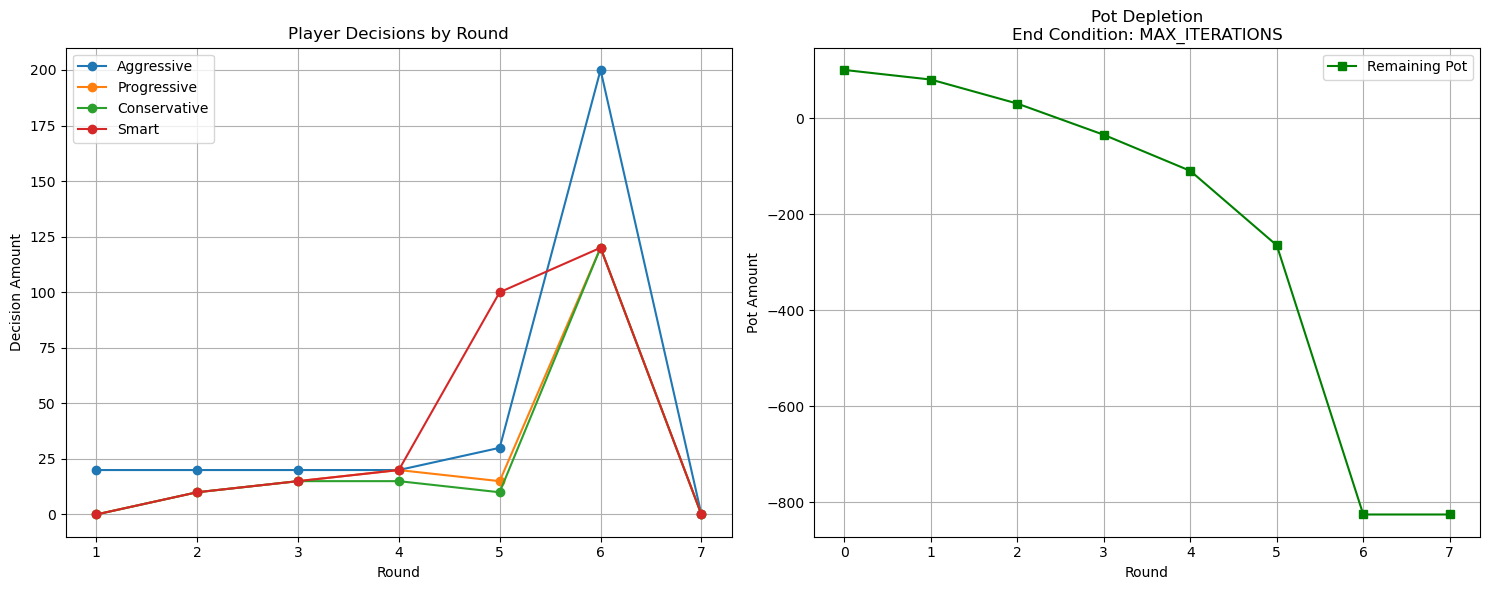

In [201]:
game.plot_game_statistics()